Kullanılan veri seti, Kaggle Dogs & Cats yarışmasından alınan veri setinin rastgele bir alt kümesidir.
* <a href="https://www.kaggle.com/c/dogs-vs-cats/overview">Veriler</a>
* Eğitim arşivi, köpek ve kedilerin 25.000 görüntüsünü içerir.
* Eğitim için 2000 Görsel (1000 Kedi / 1000 Köpek)
* Doğrulama için 400 Görsel (200 Kedi / 200 Köpek)
* Test için 100 Görsel (50 Kedi / 50 Köpek)      Kullanılmıştır.



# Connect G-Drive

In [2]:
#Colab üzerinde çalışmak için Drive Bağlantısı
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [3]:
import os 
os.chdir("/gdrive/MyDrive/Dog_Cat") 

# Import Library

In [4]:
import os
import glob
import random
import shutil
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.python.client import device_lib
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
import warnings
warnings.simplefilter(action="ignore",category=FutureWarning)

**Check GPU**

In [7]:
device = tf.config.list_physical_devices()
if(device[0][1] == "CPU"):
  print("GPU is Not Avaible")
else:
  physical_devices = tf.config.experimental.list_physical_devices('GPU')
  tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPU is Not Avaible


# Data Prepation

In [5]:
train_path = '/gdrive/MyDrive/Dog_Cat/train'
valid_path = '/gdrive/MyDrive/Dog_Cat/valid'
test_path = '/gdrive/MyDrive/Dog_Cat/test'

* ImageDataGenerator Belirtilen görüntüleri tensör görüntü verisi haline getirir.
* Her veri seti için ImageDataGenerator'a preprocessing_function=tf.keras.applications.vgg16.preprocess_input belirtiyoruz burada amaç elimizdeki verileri VGG16 modeline fit etmek için uygun hale getirmek

In [6]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


# Build VGG16 Model

* VGG, Oxford Üniversitesi'nden K. Simonyan ve A. Zisserman tarafından “Büyük Ölçekli Görüntü Tanıma için Çok Derin Evrişimli Ağlar” makalesinde önerilen evrişimli bir sinir ağı modelidir.
* Model, 1000 sınıfa ait 14 milyondan fazla görüntüden oluşan bir veri seti olan ImageNet'te %92,7'lik ilk 5 test doğruluğuna ulaşıyor.

In [11]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

553476096/553467096 [==============================] - 6s 0us/step


In [12]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
#Model varsayılan olarak indirildiğinde son katman 1000 sınıf için ayarlanmıştır bunu bu model için 2 ye düşürülmesi gerekiyor
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [14]:
#Katmanların ağırlıklarını VGG16 dan aldığı için tekrar eğitilmemesi için  katmanları eğitime kapatıyoruz
for layer in model.layers:
  layer.trainable = False

In [15]:
#En sonra 2 birimli bir çıkış katmanı ekliyoruz
model.add(Dense(units = 2 ,activation="softmax"))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

# Train VGG16 Model

In [17]:
#Modeli kaydetmek için gerekli basit fonksiyon
def save_model(model):
  model.save('dog_cat.h5')

In [18]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss="categorical_crossentropy",metrics=["accuracy"])

In [19]:
#Modelin Eğitilmesi
model.fit(x=train_batches,validation_data=valid_batches,epochs=10,verbose=2)
save_model(model)

Epoch 1/10
200/200 - 348s - loss: 0.2212 - accuracy: 0.9085 - val_loss: 0.1133 - val_accuracy: 0.9500
Epoch 2/10
200/200 - 31s - loss: 0.0684 - accuracy: 0.9790 - val_loss: 0.0815 - val_accuracy: 0.9650
Epoch 3/10
200/200 - 31s - loss: 0.0460 - accuracy: 0.9850 - val_loss: 0.0718 - val_accuracy: 0.9700
Epoch 4/10
200/200 - 31s - loss: 0.0344 - accuracy: 0.9890 - val_loss: 0.0672 - val_accuracy: 0.9750
Epoch 5/10
200/200 - 31s - loss: 0.0267 - accuracy: 0.9930 - val_loss: 0.0664 - val_accuracy: 0.9750
Epoch 6/10
200/200 - 31s - loss: 0.0205 - accuracy: 0.9960 - val_loss: 0.0735 - val_accuracy: 0.9675
Epoch 7/10
200/200 - 31s - loss: 0.0172 - accuracy: 0.9960 - val_loss: 0.0707 - val_accuracy: 0.9775
Epoch 8/10
200/200 - 31s - loss: 0.0136 - accuracy: 0.9965 - val_loss: 0.0693 - val_accuracy: 0.9750
Epoch 9/10
200/200 - 31s - loss: 0.0108 - accuracy: 0.9995 - val_loss: 0.0719 - val_accuracy: 0.9775
Epoch 10/10
200/200 - 31s - loss: 0.0089 - accuracy: 0.9990 - val_loss: 0.0732 - val_accur

In [11]:
from tensorflow.keras.models import load_model
model = load_model("dog_cat.h5")

In [12]:
#Test verilerinin tahmin edilmesi
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[50  0]
 [ 1 49]]


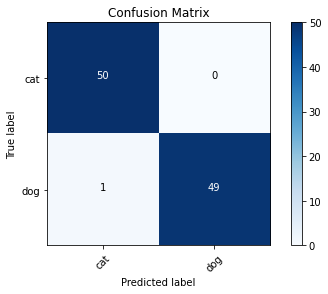

In [14]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')